In [ ]:
!pip install textstat textblob
!pip install readability-lxml
!pip install pylint

import pandas as pd
import nltk
import re
from html import unescape
import numpy as np
import textstat
from pylint.lint import Run
from pylint.reporters.text import TextReporter
import io

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.1/105.1 kB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 10.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.6/510.6 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.2/275.2 kB 11.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.3/92.3 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 8.2 MB/s eta 0:00:00


**Handling missing values**

In [ ]:
import pandas as pd

# Specify the header row when reading the CSV file
df = pd.read_csv('so_dataset_2.5k.csv', header=0, encoding='latin1', error_bad_lines=False)

df = df.loc[:, ~df.columns.str.startswith('Unnamed:')]
# df['view_count'] = pd.to_numeric(df['view_count'])
# df['answer_count'] = pd.to_numeric(df['answer_count'])


# Impute missing values with a default value (e.g., 0) for the entire DataFrame
df.fillna(0, inplace=True)

# Save the DataFrame with imputed values back to a CSV
df.to_csv('so_dataset_imputed.csv', index=False)


<ipython-input-2-751bf25d9dd6>:4: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  df = pd.read_csv('so_dataset_2.5k.csv', header=0, encoding='latin1', error_bad_lines=False)
<ipython-input-2-751bf25d9dd6>:4: DtypeWarning: Columns (0,3,4,5,7,8,12,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,20

**Clean Text and Separeate code and text**

In [ ]:
import pandas as pd
import re
from html import unescape

# Function to separate code and text from HTML body
def separate_code_and_text(html_text):
    # Find all code snippets
    code_snippets = re.findall(r'<code>(.*?)</code>', html_text, re.DOTALL)
    # Join code snippets into one string
    code = ' '.join(code_snippets)
    # Remove the code snippets from the html_text to extract the text
    text = re.sub(r'<code>.*?</code>', '', html_text)
    # Remove all remaining HTML tags
    text = re.sub(r'<[^>]+>', '', text)
    # Unescape HTML entities
    text = unescape(text)
    return code.strip(), text.strip()

# Your DataFrame loading here
df = pd.read_csv('so_dataset_imputed.csv')

# Apply the function to the 'body' column
df['code'], df['text'] = zip(*df['body'].map(separate_code_and_text))

In [ ]:
import pandas as pd
print(df.columns)

# Assuming 'df' is your DataFrame
print(df.head())  # Prints the first 5 rows of the DataFrame

Index(['question_id', 'title', 'tags', 'score', 'view_count', 'answer_count',
       'body', 'user_id', 'user_reputation', 'creation_date',
       'last_activity_date', 'user_type', 'accept_rate', 'answers', 'comments',
       'code', 'text'],
      dtype='object')
  question_id                                              title  \
0    70757929  Can I calculate the p-value and add asterisk u...   
1    70757351  How do I convert .asc data of CAN to .blf usin...   
2    70742672  Pandas `.assign` to multiple columns from sing...   
3    70741223         Removing one of the two installed Jupyters   
4    70807223  Doctest: How can I identify differences betwee...   

                                           tags score view_count answer_count  \
0        python, plotly, boxplot, plotly-python     3        793            1   
1    python, python-3.x, vector, ascii, can-bus     1       2610            1   
2                                python, pandas     2       2122            4   
3

**Temporal Features**

In [ ]:
import pandas as pd
import datetime
import html

# Function to clean and convert the date strings to datetime objects
def clean_and_convert_date(date_str):
    try:
        # Clean the HTML-encoded characters
        date_str = html.unescape(date_str)

        # Check if the date_str is a valid datetime format
        date_obj = pd.to_datetime(date_str, errors='coerce')

        # Check for NaT (Not-a-Time) values, indicating invalid datetime strings
        if pd.isna(date_obj):
            return None
        else:
            return date_obj
    except ValueError:
        # Handle unexpected values, if any, or return None
        return None

# Clean and convert 'creation_date' and 'last_activity_date' columns
df['creation_date'] = df['creation_date'].apply(clean_and_convert_date)
df['last_activity_date'] = df['last_activity_date'].apply(clean_and_convert_date)
df['score'] = pd.to_numeric(df['score'], errors='coerce')
# Now, you can perform the date-related operations as you originally intended
df['creation_hour'] = df['creation_date'].dt.hour
df['creation_weekday'] = df['creation_date'].dt.weekday
df['last_activity_hour'] = df['last_activity_date'].dt.hour
df['last_activity_weekday'] = df['last_activity_date'].dt.weekday
df['time_to_last_activity'] = (df['last_activity_date'] - df['creation_date']).dt.total_seconds() / 3600

# Save the DataFrame with the cleaned and converted date columns
df.to_csv('so_dataset_cleaned.csv', index=False)


**comments_quality**

In [ ]:
import re
import pandas as pd
from textblob import TextBlob

# Function to extract comment bodies and join them with a comma
def extract_and_join_comments(comments_str):
    if pd.isna(comments_str) or not isinstance(comments_str, str):
        return ''

    # Regular expression to match the 'body': '...' pattern
    pattern = r"'body': '(.*?)'"
    matches = re.findall(pattern, comments_str)

    # Join the extracted comments with a comma
    joined_comments = ', '.join(matches)
    return joined_comments

# Function to analyze comment sentiment
def analyze_comment_sentiment(comment):
    sentiment = TextBlob(comment).sentiment
    return sentiment.polarity

# Function to calculate comments quality
def comments_quality(comments_str):
    if not comments_str:
        return 0

    # Split the comments string by comma to get individual comments
    comments = comments_str.split(", ")

    # Define clarifying and helpful phrases
    clarifying_phrases = [
        "what do you mean", "could you explain", "I don't understand",
        "not clear", "what are you trying to", "please clarify",
        "unclear about", "didn't get what", "can you elaborate",
        "how does this", "why do you", "some examples",
        "Please explain", "What does it mean", "Is it okay",
        "Please debug", "Debug", "Correct the code",
        "Solve the problem", "Elaborate the question", "Can you fix",
        "I'm confused about", "Can you clarify", "Would you expand on",
        "Is it relevant", "can help you"
    ]
    helpful_phrases = [
        "try this", "hope this helps", "should work", "fixed your code",
        "this might help", "take a look at", "see if this works",
        "good luck", "expected output"
    ]

    quality_score = 0
    for comment in comments:
        body_lower = comment.lower()
        quality_score += sum(phrase in body_lower for phrase in clarifying_phrases)
        quality_score += 2 * sum(phrase in body_lower for phrase in helpful_phrases)
        quality_score += analyze_comment_sentiment(comment)

    return quality_score


# Apply the extraction and joining function to the 'comments' column
df['joined_comments'] = df['comments'].apply(extract_and_join_comments)

# Apply the comments_quality function
df['CommentsQuality'] = df['joined_comments'].apply(comments_quality)

# Optionally, drop the intermediate 'joined_comments' column if not needed
# df.drop('joined_comments', axis=1, inplace=True)

**question_title_complexity**

In [ ]:
import nltk
from nltk.corpus import wordnet as wn
from nltk.corpus import brown  # Add this import to use the Brown corpus

# Download necessary NLTK data
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('brown')  # Download the Brown corpus

# Generate a frequency distribution of words in the Brown corpus
freq_dist = nltk.FreqDist(w.lower() for w in brown.words())

# This is an example list, you should expand it with a comprehensive set of technical terms relevant to your domain
technical_terms = set([
    'python', 'dataframe', 'concatenate', 'csv', 'selenium', 'numpy', 'pandas',
    'list', 'dict', 'tuple', 'set', 'str', 'int', 'float', 'bool',
    'matplotlib', 'script', 'flask', 'django', 'api', 'request', 'json',
    'pip', 'venv', 'virtualenv', 'pycharm', 'jupyter', 'notebook', 'lambda',
    'function', 'class', 'method', 'attribute', 'inheritance', 'polymorphism',
    'encapsulation', 'async', 'await', 'thread', 'multiprocessing', 'socket',
    'scipy', 'tensorflow', 'keras', 'pytorch', 'machine learning', 'deep learning',
    'sklearn', 'scikit-learn', 'plot', 'graph', 'visualization', 'data analysis',
    'regex', 'regular expression', 'beautifulsoup', 'web scraping', 'lxml',
    'sqlalchemy', 'orm', 'database', 'sql', 'nosql', 'mongodb', 'postgresql',
    'unittest', 'pytest', 'test', 'docker', 'container', 'git', 'version control',
    'cli', 'command line', 'interface', 'module', 'package', 'distribution',
    'pep8', 'style guide', 'typing', 'type hint', 'annotation', 'asyncio',
    'concurrency', 'parallelism', 'decorator', 'context manager', 'generator',
    'yield', 'comprehension', 'list comprehension', 'dict comprehension',
    'exception', 'error handling', 'traceback', 'debug', 'logging',
    'environment variable', 'config', 'yaml', 'toml', 'xml', 'etree',
    'pillow', 'image processing', 'opencv', 'array', 'tensor', 'data structure',
    'algorithm', 'recursion', 'iterable', 'iterator', 'protocol', 'descriptors',
    'metaclass', 'magic method', 'dunder method', 'garbage collection',
    'memory management', 'optimization', 'performance', 'cython', 'c extension'
])


def word_is_technical(word):
    return word in technical_terms

def question_title_complexity(title):
    words = nltk.word_tokenize(title)  # Use NLTK's tokenizer instead of split()

    length_score = len(words)
    vocab_difficulty = textstat.dale_chall_readability_score(title)
    syntactic_complexity = len(re.findall(r'\b(and|or|but|if|while|which)\b', title))

    pos_tags = nltk.pos_tag(words)
    noun_count = sum(1 for word, pos in pos_tags if pos.startswith('NN'))
    verb_count = sum(1 for word, pos in pos_tags if pos.startswith('VB'))
    hypernym_counts = sum(len(wn.synsets(word)) for word in words)

    # New step: Count technical terms and calculate their frequency
    technical_term_count = sum(1 for word in words if word_is_technical(word.lower()))
    technical_term_frequency = sum(freq_dist[word.lower()] for word in words if word_is_technical(word.lower()))

    # Normalize the new metrics
    normalized_technical_term_count = technical_term_count / 10  # assuming at most 10 technical terms in a title
    normalized_technical_term_frequency = technical_term_frequency / 1000  # adjust this based on your observation of the frequencies

    complexity_score = (length_score + vocab_difficulty + syntactic_complexity + noun_count +
                        verb_count + hypernym_counts + normalized_technical_term_count -
                        normalized_technical_term_frequency) / 7  # Now dividing by 7 due to the addition of a new metric

    return complexity_score

# Apply the updated function to the DataFrame
df['QuestionTitleComplexity'] = df['title'].apply(question_title_complexity)


[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Unzipping corpora/brown.zip.


**Get code quality score**

In [ ]:
import os

In [ ]:
import io
import tempfile  # Add this import for tempfile
import os
import pandas as pd
from pylint.lint import Run
from pylint.reporters.text import TextReporter

def get_code_quality_score(code_string):
    pylint_output = io.StringIO()
    exit_code = None

    with tempfile.NamedTemporaryFile(mode='w', delete=False, suffix='.py') as temp_file:
        temp_file_name = temp_file.name
        temp_file.write(code_string)

    try:
        # Run pylint on the temporary file
        lint = Run([temp_file_name], reporter=TextReporter(pylint_output), exit=False)
        # Retrieve the final score if available
        score = lint.linter.stats.global_note if hasattr(lint.linter.stats, 'global_note') else 0
        # Normalize the score from -10 to 10 scale to 0 to 10 scale
        normalized_score = (score + 10) / 2
        # Retrieve the exit code
        exit_code = lint.linter.msg_status
    except Exception as e:
        # Handle exceptions
        print(f"An error occurred while running pylint: {e}")
    finally:
        # Clean up the temporary file
        try:
            os.remove(temp_file_name)
        except OSError as e:
            print(f"Error removing the temporary file: {e}")

    # Return the normalized score, the pylint output, and the exit code
    return normalized_score, pylint_output.getvalue(), exit_code

# Assuming df['code'] contains the code snippets as strings
df['code_quality_results'] = df['code'].apply(get_code_quality_score)
results = df['code'].apply(get_code_quality_score)
df['normalized_score'], df['pylint_output'], df['exit_code'] = zip(*results)

# Apply the function and split the results into three new columns
df[['normalized_score', 'pylint_output', 'exit_code']] = df.apply(
    lambda row: pd.Series(get_code_quality_score(row['code'])), axis=1)
for index, row in df.iterrows():
    print(f"Row {index} results:")
    print(f"Code Quality Score: {row['normalized_score']}")
    print(f"Pylint Output:\n{row['pylint_output']}")
    print(f"Exit Code: {row['exit_code']}")
    print("-" * 40)  # Print a separator line


Streaming output truncated to the last 5000 lines.
/tmp/tmpa4hl35_z.py:3:22: E0001: Parsing failed: 'invalid syntax (<unknown>, line 3)' (syntax-error)

Exit Code: 2
----------------------------------------
Row 1500 results:
Code Quality Score: 5.0
Pylint Output:
************* Module tmpo46840jt
/tmp/tmpo46840jt.py:11:35: E0001: Parsing failed: 'invalid syntax (<unknown>, line 11)' (syntax-error)

Exit Code: 2
----------------------------------------
Row 1501 results:
Code Quality Score: 5.0
Pylint Output:
************* Module tmp86y6bzny
/tmp/tmp86y6bzny.py:1:15: E0001: Parsing failed: 'invalid syntax (<unknown>, line 1)' (syntax-error)

Exit Code: 2
----------------------------------------
Row 1502 results:
Code Quality Score: 5.0
Pylint Output:
************* Module tmptchn7ahh
/tmp/tmptchn7ahh.py:2:8: E0001: Parsing failed: 'invalid syntax (<unknown>, line 2)' (syntax-error)

Exit Code: 2
----------------------------------------
Row 1503 results:
Code Quality Score: 5.0
Pylint Outpu

In [ ]:
!pip install radon

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.8/52.8 kB 975.9 kB/s eta 0:00:00


**calculate_answers_quality**

In [ ]:
import re

def calculate_answers_quality(answer):
    # Initialize score
    quality_score = 0

    # Criteria 1: Check for phrases indicating correctness
    correctness_phrases = [
'this works',
'solves the problem',
'correct',
'accurate',
'valid',
'right',
'proper',
'error-free',
'bug-free',
'functioning as expected',
'meets requirements',
'passes all tests',
'working as intended',
'no issues found',
'no errors detected',
'no problems encountered',
'no anomalies',
'no unexpected behavior',
'no deviations from specifications',
'no violations of constraints',
'no deviations from the expected behavior',
]
    for phrase in correctness_phrases:
        if phrase in answer.lower():
            quality_score += 10  # Add points for correctness

    # Criteria 2: Check for completeness
    if '<code>' in answer and '</code>' in answer:
        quality_score += 5  # Add points for code snippet

    # Criteria 3: Check for links to documentation or other references
    if 'http' in answer:
        quality_score += 5  # Add points for references

    # Criteria 4: Check for clarity by simple length heuristic (you might want more sophisticated checks)
    if len(answer.split()) > 50:
        quality_score += 5  # Add points for a longer, potentially more detailed answer

    # Criteria 5: Deduct points for poor formatting
    if '...' in answer or answer.isupper():
        quality_score -= 5  # Deduct points for formatting issues

    return quality_score


# Apply the function to each answer in the DataFrame
df['AnswersQuality'] = df['body'].apply(calculate_answers_quality)


**Tag Relevancy**

In [ ]:
def tag_relevance(row):
    # Extract tags from the row
    tags = row['tags'].split(', ')
    # Initialize the relevance score
    relevance_score = 0

    # Check if 'text' is a string and convert to lowercase if so
    text = row['text'].lower() if isinstance(row['text'], str) else ""
    # Check if 'code' is a string and convert to lowercase if so
    code = row['code'].lower() if isinstance(row['code'], str) else ""

    # For each tag, check if it's in the body or code and increment relevance score
    for tag in tags:
        if tag in text:
            relevance_score += 1
        if tag in code:
            relevance_score += 1

    # Normalize the relevance score by the total number of tags
    relevance_score /= len(tags) * 2  # multiply by 2 as we check both body and code
    return relevance_score

# Apply the function to the DataFrame
df['TagRelevance'] = df.apply(tag_relevance, axis=1)


**UserReputationWeighted**

In [ ]:
import numpy as np

# Function to clean and convert user_reputation values
def clean_and_convert_user_reputation(value):
    try:
        # If it's a string in JSON-like format, extract the numeric part
        if isinstance(value, str) and '"type":"address"' in value:
            # Extract the numeric part from the JSON-like string
            numeric_part = value.split('"reputation":')[-1].split('}')[0]
            return float(numeric_part)
        # Otherwise, try to convert to float directly
        return float(value)
    except (ValueError, TypeError):
        # Handle conversion errors by returning NaN (or any suitable default)
        return np.nan

# Apply the clean_and_convert_user_reputation function to the 'user_reputation' column
df['UserReputationWeighted'] = df['user_reputation'].apply(clean_and_convert_user_reputation)

# Apply a logarithmic transformation to the 'UserReputationWeighted' column
# Add 1 to avoid log(0) which is undefined
df['UserReputationWeighted'] = np.log1p(df['UserReputationWeighted'])


**Text Readability**

In [ ]:
import textstat

df['text_readability'] = df['body'].apply(textstat.flesch_reading_ease)

import textstat

def calculate_readability(text):
    return {
        "flesch_reading_ease": textstat.flesch_reading_ease(text),
    }

**sentiment_polarity**

In [ ]:
from textblob import TextBlob

# Ensure that 'cleaned_body' is a string and not missing
df['cleaned_body'] = df['body'].astype(str)

# Calculate sentiment polarity for the 'cleaned_body' column
df['sentiment_polarity'] = df['cleaned_body'].apply(lambda x: TextBlob(x).sentiment.polarity)

**no of comments**

In [ ]:
def count_comments(comments_str):
    return comments_str.count("'owner'")
df['no_of_comments'] = df['comments'].apply(count_comments)

**survey weight**

In [ ]:
import pandas as pd

# Assuming `survey_df` is your DataFrame containing the survey results
survey_df = pd.read_csv('survey.csv')
# Convert to numeric and calculate the mean for each feature column
feature_means = survey_df[['Question Title', 'Code Body', 'Tags', 'User Reputation', 'Comments on Question', 'Number of Answers']].apply(pd.to_numeric, errors='coerce').mean()

# Normalize the mean weights so that they sum up to 1
total = feature_means.sum()
normalized_weights = feature_means / total

# The `normalized_weights` Series now contains the weight for each feature
print(normalized_weights)


Question Title          0.237981
Code Body               0.201923
Tags                    0.134615
User Reputation         0.091346
Comments on Question    0.170673
Number of Answers       0.163462
dtype: float64


**Comprehensibility**

1st approach

In [ ]:
import pandas as pd

# Convert columns to 'float64' data type
columns_to_convert = ['view_count', 'answer_count', 'user_reputation', 'accept_rate', 'normalized_score', 'AnswersQuality', 'TagRelevance', 'UserReputationWeighted']
for column in columns_to_convert:
    df[column] = pd.to_numeric(df[column], errors='coerce').astype(float)

# Updated weights (already normalized)
weights = {
    'QuestionTitleComplexity': 0.204969,
    'normalized_score': 0.173913,  # code body
    'TagRelevance': 0.115942,
    'UserReputationWeighted': 0.078675,
    'CommentsQuality': 0.146998,
    'answer_count': 0.140787
}

def calculate_comprehensibility(row):
    score = 0
    for feature, weight in weights.items():
        # Access DataFrame columns using loc
        feature_value = row.loc[feature]
        score += weight * feature_value
    return score

# Add a new column to the DataFrame by applying the function to each row
df['comprehensibility'] = df.apply(calculate_comprehensibility, axis=1)


In [ ]:
import pandas as pd
print(df.columns)

# Assuming 'df' is your DataFrame
print(df.head())  # Prints the first 5 rows of the DataFrame

Index(['question_id', 'title', 'tags', 'score', 'view_count', 'answer_count',
       'body', 'user_id', 'user_reputation', 'creation_date',
       'last_activity_date', 'user_type', 'accept_rate', 'answers', 'comments',
       'code', 'text', 'creation_hour', 'creation_weekday',
       'last_activity_hour', 'last_activity_weekday', 'time_to_last_activity',
       'joined_comments', 'CommentsQuality', 'QuestionTitleComplexity',
       'code_quality_results', 'normalized_score', 'pylint_output',
       'exit_code', 'AnswersQuality', 'TagRelevance', 'UserReputationWeighted',
       'text_readability', 'cleaned_body', 'sentiment_polarity',
       'no_of_comments', 'comprehensibility'],
      dtype='object')
  question_id                                              title  \
0    70757929  Can I calculate the p-value and add asterisk u...   
1    70757351  How do I convert .asc data of CAN to .blf usin...   
2    70742672  Pandas `.assign` to multiple columns from sing...   
3    70741223  

2nd approach

In [ ]:
# Ensure all columns are numeric
columns_to_check = ['sentiment_polarity', 'text_readability', 'QuestionTitleComplexity',
                    'normalized_score', 'view_count', 'answer_count', 'no_of_comments',
                    'AnswersQuality', 'CommentsQuality', 'TagRelevance','UserReputationWeighted']

for col in columns_to_check:
    if not pd.api.types.is_numeric_dtype(df[col]):
        df[col] = pd.to_numeric(df[col], errors='coerce')  # Convert to numeric, make non-convertible values NaN

# Handle NaN values if necessary
df.fillna(0, inplace=True)  # or any other method of handling NaNs

# Recalculate the normalized columns
df['NormalizedReputation'] = df['UserReputationWeighted'] / df['UserReputationWeighted'].max()
df['NormalizedClarity'] = (df['sentiment_polarity'] + df['text_readability']+df['AnswersQuality'] + df['CommentsQuality']) / 4
df['NormalizedComplexity'] = (df['QuestionTitleComplexity'] + df['normalized_score']) / 2
df['NormalizedEngagement'] = (df['view_count'] + df['answer_count'] + df['no_of_comments']) / 3
df['NormalizedRelevance'] = df['TagRelevance'] / df['TagRelevance'].max()


# Assigning weights to the components
weights = {
    'clarity': 0.2,
    'complexity': 0.2,
    'engagement': 0.2,
    'reputation': 0.2,
    'relevance': 0.2
}

# Calculating the comprehensibility score
df['ComprehensibilityScore'] = (
    df['NormalizedClarity'] * weights['clarity'] +
    df['NormalizedComplexity'] * weights['complexity'] +
    df['NormalizedEngagement'] * weights['engagement'] +
    df['NormalizedReputation'] * weights['reputation'] +
    df['NormalizedRelevance'] * weights['relevance']
)


In [ ]:
import pandas as pd
print(df.columns)

# Assuming 'df' is your DataFrame
print(df.head())  # Prints the first 5 rows of the DataFrame

Index(['question_id', 'title', 'tags', 'score', 'view_count', 'answer_count',
       'body', 'user_id', 'user_reputation', 'creation_date',
       'last_activity_date', 'user_type', 'accept_rate', 'answers', 'comments',
       'code', 'text', 'creation_hour', 'creation_weekday',
       'last_activity_hour', 'last_activity_weekday', 'time_to_last_activity',
       'joined_comments', 'CommentsQuality', 'QuestionTitleComplexity',
       'code_quality_results', 'normalized_score', 'pylint_output',
       'exit_code', 'AnswersQuality', 'TagRelevance', 'UserReputationWeighted',
       'text_readability', 'cleaned_body', 'sentiment_polarity',
       'no_of_comments', 'comprehensibility', 'NormalizedClarity',
       'NormalizedComplexity', 'NormalizedEngagement', 'NormalizedRelevance',
       'ComprehensibilityScore'],
      dtype='object')
  question_id                                              title  \
0    70757929  Can I calculate the p-value and add asterisk u...   
1    70757351  How 

In [ ]:
# print(df['Comprehensibility'])
df.to_csv('processed dataset.csv', index=False)


<ipython-input-31-89c23c250a5f>:8: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = df.corr()


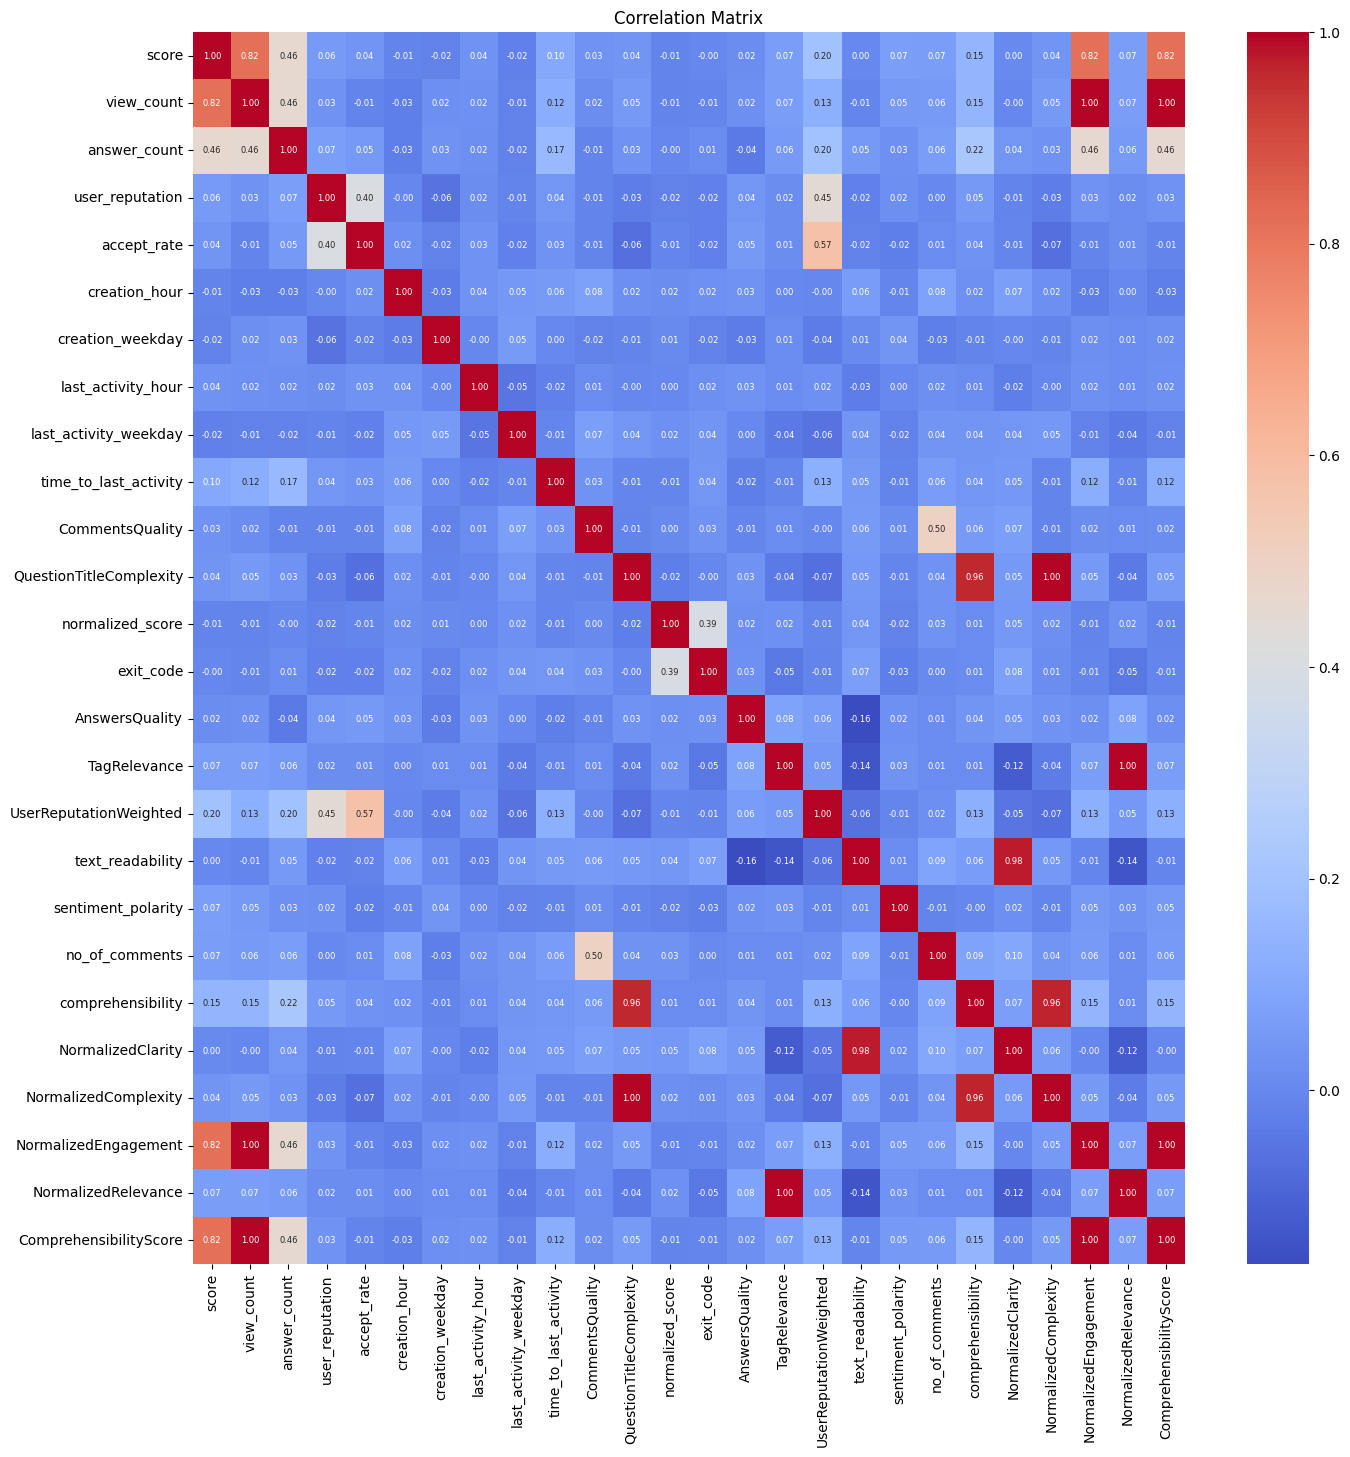

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming df is your DataFrame

# Calculate the correlation matrix
correlation_matrix = df.corr()

# You can now use seaborn or matplotlib to visualize this matrix
plt.figure(figsize=(16, 16))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', annot_kws={"size": 6})
plt.title('Correlation Matrix')
plt.show()


**correlation**

<ipython-input-26-dcd937d937e0>:17: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  new_correlation_matrix = new_correlation_data.corr()


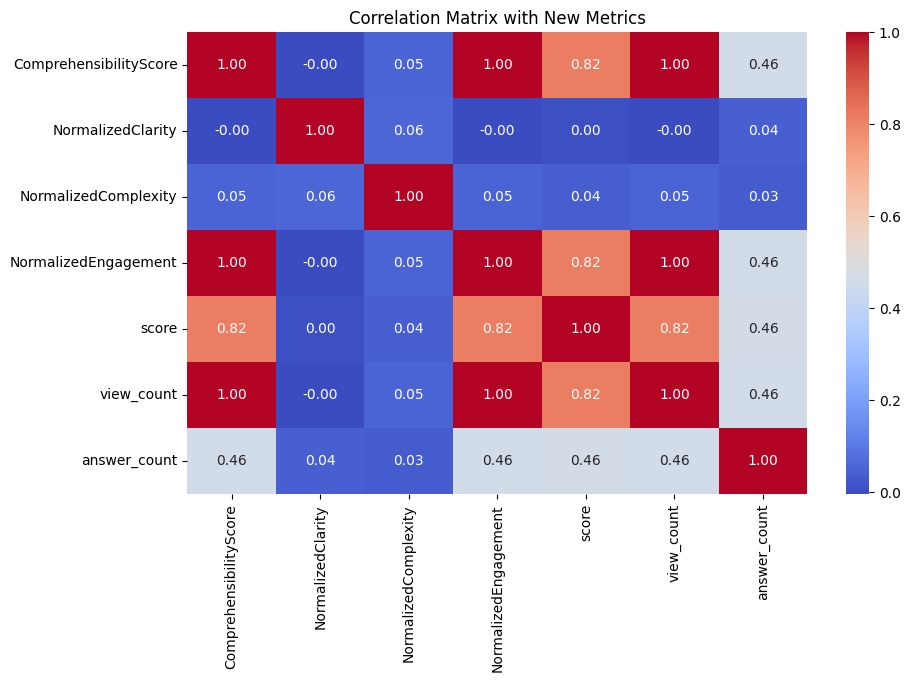

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Assuming 'new_data' is your DataFrame
# You would first read your dataset as follows:
new_data = pd.read_csv('processed dataset.csv')

# Selecting the columns for the correlation matrix
new_correlation_data = new_data[
    ['ComprehensibilityScore', 'NormalizedClarity', 'NormalizedComplexity',
     'NormalizedEngagement', 'score', 'view_count', 'answer_count',
     'user_reputation']
]

# Calculating the correlation matrix
new_correlation_matrix = new_correlation_data.corr()

# Plotting the heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(new_correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix with New Metrics')
plt.show()


In [ ]:

# Import necessary libraries
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, f1_score, precision_score, roc_auc_score

from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Conv1D, MaxPooling1D, Flatten
from tensorflow.keras.models import Sequential

# Assuming you have already loaded and preprocessed your data into X (features) and y (target).
df = pd.read_csv('processed dataset.csv')
# # Define your features (X) and target variable (y)
X = df[['ComprehensibilityScore']]  # Replace 'comprehensibility' with the actual column name
y = df['score']
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize features (for SVR and KNN)
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)
X_test_std = scaler.transform(X_test)

# Linear Regression
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
lr_predictions = lr_model.predict(X_test)
lr_mse = mean_squared_error(y_test, lr_predictions)
lr_r2 = r2_score(y_test, lr_predictions)
lr_mae = mean_absolute_error(y_test, lr_predictions)
print("Model: Linear Regression")
print("Mean Squared Error:", lr_mse)
print("R-squared:", lr_r2)
print("Mean Absolute Error:", lr_mae)

# Random Forest Regression
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
rf_predictions = rf_model.predict(X_test)
rf_mse = mean_squared_error(y_test, rf_predictions)
rf_r2 = r2_score(y_test, rf_predictions)
rf_mae = mean_absolute_error(y_test, rf_predictions)
print("\nModel: Random Forest Regression")
print("Mean Squared Error:", rf_mse)
print("R-squared:", rf_r2)
print("Mean Absolute Error:", rf_mae)

# Gradient Boosting Regression
gb_model = GradientBoostingRegressor(n_estimators=100, random_state=42)
gb_model.fit(X_train, y_train)
gb_predictions = gb_model.predict(X_test)
gb_mse = mean_squared_error(y_test, gb_predictions)
gb_r2 = r2_score(y_test, gb_predictions)
gb_mae = mean_absolute_error(y_test, gb_predictions)
print("\nModel: Gradient Boosting Regression")
print("Mean Squared Error:", gb_mse)
print("R-squared:", gb_r2)
print("Mean Absolute Error:", gb_mae)

# Support Vector Regression (SVR)
svr_model = SVR(kernel='linear')
svr_model.fit(X_train_std, y_train)
svr_predictions = svr_model.predict(X_test_std)
svr_mse = mean_squared_error(y_test, svr_predictions)
svr_r2 = r2_score(y_test, svr_predictions)
svr_mae = mean_absolute_error(y_test, svr_predictions)
print("\nModel: Support Vector Regression")
print("Mean Squared Error:", svr_mse)
print("R-squared:", svr_r2)
print("Mean Absolute Error:", svr_mae)

# k-Nearest Neighbors (KNN)
knn_model = KNeighborsRegressor(n_neighbors=5)
knn_model.fit(X_train_std, y_train)
knn_predictions = knn_model.predict(X_test_std)
knn_mse = mean_squared_error(y_test, knn_predictions)
knn_r2 = r2_score(y_test, knn_predictions)
knn_mae = mean_absolute_error(y_test, knn_predictions)
print("\nModel: k-Nearest Neighbors (KNN)")
print("Mean Squared Error:", knn_mse)
print("R-squared:", knn_r2)
print("Mean Absolute Error:", knn_mae)

# Long Short-Term Memory (LSTM) Network
lstm_model = Sequential()
lstm_model.add(LSTM(50, activation='relu', input_shape=(X_train.shape[1], 1)))
lstm_model.add(Dense(1))
lstm_model.compile(optimizer='adam', loss='mean_squared_error')
X_train_lstm = np.expand_dims(X_train, axis=2)
X_test_lstm = np.expand_dims(X_test, axis=2)
lstm_model.fit(X_train_lstm, y_train, epochs=10, batch_size=32)
lstm_predictions = lstm_model.predict(X_test_lstm)
lstm_mse = mean_squared_error(y_test, lstm_predictions)
lstm_r2 = r2_score(y_test, lstm_predictions)
lstm_mae = mean_absolute_error(y_test, lstm_predictions)
print("\nModel: Long Short-Term Memory (LSTM) Network")
print("Mean Squared Error:", lstm_mse)
print("R-squared:", lstm_r2)
print("Mean Absolute Error:", lstm_mae)

# You can further tune hyperparameters for these models to optimize their performance.




Model: Linear Regression
Mean Squared Error: 15.479612762430907
R-squared: 0.7819134921758623
Mean Absolute Error: 1.3288519767795306

Model: Random Forest Regression
Mean Squared Error: 26.73952945368171
R-squared: 0.623276713125068
Mean Absolute Error: 1.6831591448931116

Model: Gradient Boosting Regression
Mean Squared Error: 49.36006962581846
R-squared: 0.30458433451402767
Mean Absolute Error: 1.5602384959949633

Model: Support Vector Regression
Mean Squared Error: 13.627584433006165
R-squared: 0.8080060305974879
Mean Absolute Error: 1.2304296295414483

Model: k-Nearest Neighbors (KNN)
Mean Squared Error: 31.058337292161525
R-squared: 0.5624306355188176
Mean Absolute Error: 1.631828978622328
Epoch 1/10
53/53 [==============================] - 2s 3ms/step - loss: 1351.1014
Epoch 2/10
53/53 [==============================] - 0s 3ms/step - loss: 30.1840
Epoch 3/10
53/53 [==============================] - 0s 3ms/step - loss: 29.0031
Epoch 4/10
53/53 [==============================] - 0

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

# Load the dataset
df = pd.read_csv('processed dataset.csv')

# Select features and target variable
X = df.drop('ComprehensibilityScore', axis=1)  # All other columns are features
y = df['ComprehensibilityScore']  # Target variable

# Preprocessing
# Convert all columns to numeric and fill NaN values if not already done
X = X.apply(pd.to_numeric, errors='coerce')
X.fillna(0, inplace=True)

# Scaling the features (optional but recommended)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Model selection
model = RandomForestRegressor(n_estimators=100, random_state=42)

# Training the model
model.fit(X_train, y_train)

# Predicting the Test set results
y_pred = model.predict(X_test)

# Evaluating the model
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

# Further steps would include hyperparameter tuning and cross-validation


Mean Squared Error: 177568.2405643322
